In [1]:
import numpy as np 
import matplotlib.pyplot as plt

## 문제 1) PCA using power iteration

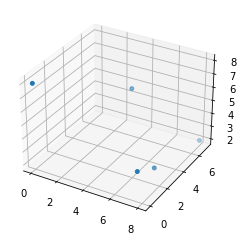

In [99]:
from mpl_toolkits.mplot3d import Axes3D as ax

X=np.random.randint(10, size=15).reshape(-1,3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], marker='o', s=15)
plt.show()

In [104]:
def power_iteration(X, num_iter, epsilon):
    n, d = X.shape
    b_k = np.random.rand(d)
    
    for _ in range(num_iter):
        # 주어진 행렬과 곱하기
        b_k1 = np.dot(X, b_k)
        
        # 정규화
        b_k1_norm = np.linalg.norm(b_k1)
        
        # 다음 단계를 위해 업데이트
        b_k_next = b_k1 / b_k1_norm
        
        # 수렴 확인
        if np.linalg.norm(b_k_next[:d] - b_k) < epsilon:
            return b_k_next[:d]
        
        b_k = b_k_next[:d]
        
    return b_k

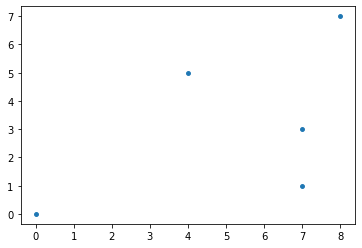

In [105]:
convert_mat = power_iteration(X, num_iter=2, epsilon=1e-10)
proj_X = X.dot(convert_mat)

plt.scatter(X[:,0], X[:,1], marker='o', s=15)
plt.show()

## MNIST data load & preprocessing

In [84]:
from dataset.mnist import load_mnist

(train_raw_img, train_y), (test_raw_img, test_y) = load_mnist(flatten=False, normalize=False)

In [85]:
# reshape 
train_X = train_raw_img.reshape(len(train_raw_img.squeeze()), -1)
test_X = test_raw_img.reshape(len(test_raw_img.squeeze()), -1)

# nomaization 1 (set value 0 ~ 1)
train_X = train_X.astype('float')/255
test_X = test_X.astype('float')/255

# nomaization 2 (be cetered)
train_X = train_X - train_X.mean(axis=1)[:,np.newaxis]
test_X = test_X - test_X.mean(axis=1)[:,np.newaxis]

In [86]:
def visualization(proj_X, y) :
    data = proj_X[:100].reshape(-1,2) # 시각화용 데이터 100개
    label = y[:100]
    
    digit_color=['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
    for label, x, y in zip(label, data[:, 0], data[:, 1]):
        plt.annotate(label, xy=(x, y))
        plt.scatter(x, y, color=digit_color[label])

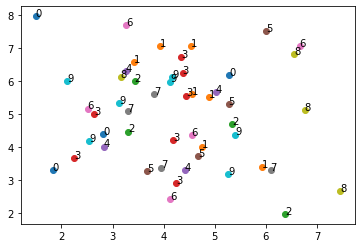

In [87]:
convert_mat = power_iteration(train_X, num_iter=2, epsilon=1e-10) # reduce to 2D
proj_X = train_X.dot(convert_mat)

visualization(proj_X, train_y)

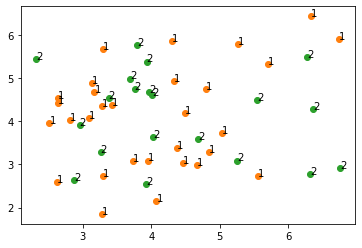

In [88]:
# 두 클래스 간의 비교를 위한 visualziation
mask = (train_y==1) | (train_y==2)
tmp_data = proj_X[mask]
tmp_label = train_y[mask]

visualization(tmp_data, tmp_label)

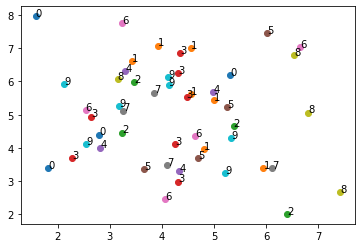

In [89]:
convert_mat = power_iteration(train_X, num_iter=200, epsilon=1e-10) # reduce to 2D
proj_X = train_X.dot(convert_mat)

visualization(proj_X, train_y)

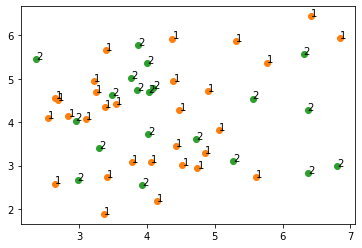

In [90]:
# 두 클래스 간의 비교를 위한 visualziation
mask = (train_y==1) | (train_y==2)
tmp_data = proj_X[mask]
tmp_label = train_y[mask]

visualization(tmp_data, tmp_label)

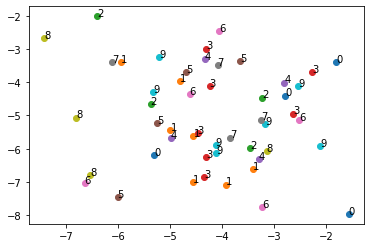

In [91]:
convert_mat = power_iteration(train_X, num_iter=2000, epsilon=1e-10) # reduce to 2D
proj_X = train_X.dot(convert_mat)

visualization(proj_X, train_y)

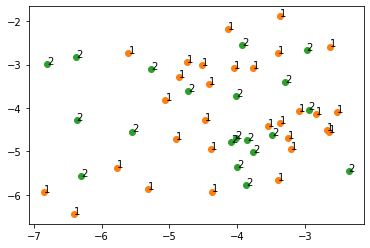

In [92]:
# 두 클래스 간의 비교를 위한 visualziation
mask = (train_y==1) | (train_y==2)
tmp_data = proj_X[mask]
tmp_label = train_y[mask]

visualization(tmp_data, tmp_label)

## 문제 2) PCA + linear model

### input size -> hidden size -> class size : 784 -> (optional) -> 10

## model

In [93]:
class Linear:
    def __init__(self, input_size=1, hidden_size=1):
        self.W = np.random.randn(input_size, hidden_size)
        self.b = np.zeros(hidden_size)
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout, lr):
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.x.T, dout)
        dx = np.dot(dout, self.W.T)
        
        self.W -= lr * self.dW
        self.b -= lr * self.db
        
        return dx

In [94]:
class Softmax_with_CrossEntropy :
    def __init__(self) :
        # softmax
        self.softmax_x = None 
        self.softmax_out = None
        # crossEntropy
        self.pred = None
        self.target = None
        self.delta = 1e-7
        
    def softmax_forward(self, x) :
        self.softmax_x = x
        tmp = np.max(self.softmax_x, axis=1).reshape(-1, 1)
        self.softmax_out = np.exp(self.softmax_x-tmp)/np.sum(np.exp(self.softmax_x-tmp), axis=1).reshape(-1,1)
        return self.softmax_out
    
    def crossEntropy_forward(self, pred, target) :
        self.pred = pred
        self.target = target
        loss = -np.sum(self.target*np.log(self.pred+self.delta), axis=1)
        return loss
    
    def backward(self) :
        dout = (self.pred-self.target)/len(self.pred)
        return dout

In [95]:
# eval 함수 구현
def eval(model, vectors, train_version=True):
    if train_version:
        x = train_X @ vectors
        labels = train_y.squeeze()
        print('In train dataset ... ')
    else: 
        x = test_X @ vectors
        labels = test_y.squeeze()
        print('\nIn test dataset ... ')
    
    for layer in model.values():
        if isinstance(layer, Softmax_with_CrossEntropy):
            x = layer.softmax_forward(x)
        else:
            x = layer.forward(x)
            
    preds = x.argmax(axis=1)
    acc = np.sum(np.where(preds==labels, True, False))/len(labels)
    return acc

## Train / Eval

In [96]:
# one_hot label 만드는 함수
def make_one_hot(labels) :
    a = []
    for label in labels :
        one_hot = np.zeros(10)
        one_hot[label] = 1
        a.append(one_hot)
    a = np.array(a)
    return a

one_hot_labels = make_one_hot(train_y)
print(train_y[0])
print(one_hot_labels[0])

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [134]:
train_X.shape

(60000, 784)

In [108]:
from collections import OrderedDict

def train(train_X, train_y, config, M):
    # 손실 이력을 저장하는 리스트
    loss_history = []
    
    lr, num_epoch = config['learning_rate'], config['num_epoch']
    print_loss_interval = 25
    
    # PCA application
    vectors = np.zeros((train_X.shape[1], M))
    for i in range(M):
        vector = power_iteration(train_X, num_iter=M, epsilon=1e-5)
        train_X = train_X - train_X @ vector.reshape(-1,1) * vector
        vectors[:, i] = vector

    train_X_pca = train_X @ vectors
    
    layer = Linear(M, 10)
    softmax_with_CE = Softmax_with_CrossEntropy()
    
    for iter in range(num_epoch) :
        # forward
        x = layer.forward(train_X_pca)
        preds = softmax_with_CE.softmax_forward(x)
        
        # loss
        one_hot_labels = make_one_hot(train_y)
        losses = softmax_with_CE.crossEntropy_forward(preds, one_hot_labels)
        loss = losses.sum()/len(preds)
        
        # 손실 이력에 손실 값을 추가
        loss_history.append(loss)
        
        # backward
        dL = softmax_with_CE.backward()
        dL = layer.backward(dL, lr)
        
        if iter == 0 or (iter+1) % print_loss_interval == 0:
            print("[epoch %d / %d] average loss : %f" % (iter+1, num_epoch, loss))
    
    # 손실 그래프
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    
    model = OrderedDict()
    model['layer'] = layer
    model['softmax_with_CE'] = softmax_with_CE
    
    return model, vectors

### M = 10

[epoch 1 / 100] average loss : 2.307565
[epoch 25 / 100] average loss : 2.307335
[epoch 50 / 100] average loss : 2.307106
[epoch 75 / 100] average loss : 2.306888
[epoch 100 / 100] average loss : 2.306679


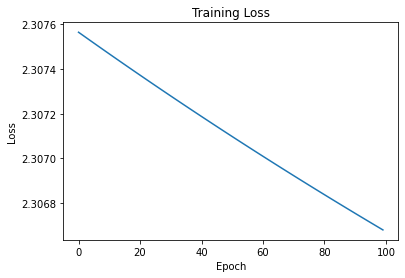

In [119]:
# ppt에서 주어진 값
config = { 'learning_rate' : 0.01,
            'num_epoch' : 100
          }

model1, vectors1 = train(train_X, train_y, config, 10)

In [120]:
print('\t Accuracy :', eval(model1, vectors1, train_version=True))
print('\t Accuracy :', eval(model1, vectors1, train_version=False))

In train dataset ... 
	 Accuracy : 0.08763333333333333

In test dataset ... 
	 Accuracy : 0.0904


[epoch 1 / 1000] average loss : 2.302886
[epoch 25 / 1000] average loss : 2.302625
[epoch 50 / 1000] average loss : 2.302364
[epoch 75 / 1000] average loss : 2.302114
[epoch 100 / 1000] average loss : 2.301874
[epoch 125 / 1000] average loss : 2.301644
[epoch 150 / 1000] average loss : 2.301422
[epoch 175 / 1000] average loss : 2.301210
[epoch 200 / 1000] average loss : 2.301006
[epoch 225 / 1000] average loss : 2.300810
[epoch 250 / 1000] average loss : 2.300621
[epoch 275 / 1000] average loss : 2.300440
[epoch 300 / 1000] average loss : 2.300265
[epoch 325 / 1000] average loss : 2.300097
[epoch 350 / 1000] average loss : 2.299935
[epoch 375 / 1000] average loss : 2.299779
[epoch 400 / 1000] average loss : 2.299629
[epoch 425 / 1000] average loss : 2.299484
[epoch 450 / 1000] average loss : 2.299344
[epoch 475 / 1000] average loss : 2.299209
[epoch 500 / 1000] average loss : 2.299079
[epoch 525 / 1000] average loss : 2.298953
[epoch 550 / 1000] average loss : 2.298831
[epoch 575 / 100

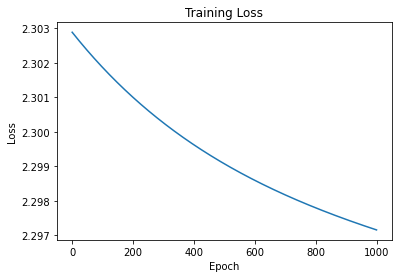

In [121]:
config = { 'learning_rate' : 0.01,
            'num_epoch' : 1000
          }

model1, vectors1 = train(train_X, train_y, config, 10)

In [122]:
print('\t Accuracy :', eval(model1, vectors1, train_version=True))
print('\t Accuracy :', eval(model1, vectors1, train_version=False))

In train dataset ... 
	 Accuracy : 0.10346666666666667

In test dataset ... 
	 Accuracy : 0.0981


### M = 100

[epoch 1 / 100] average loss : 2.315611
[epoch 25 / 100] average loss : 2.314689
[epoch 50 / 100] average loss : 2.313760
[epoch 75 / 100] average loss : 2.312863
[epoch 100 / 100] average loss : 2.311995


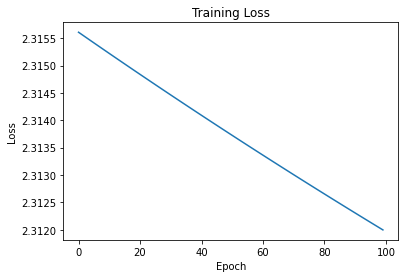

In [124]:
# ppt에서 주어진 값
config = { 'learning_rate' : 0.01,
            'num_epoch' : 100
          }

model1, vectors1 = train(train_X, train_y, config, 100)

In [125]:
print('\t Accuracy :', eval(model1, vectors1, train_version=True))
print('\t Accuracy :', eval(model1, vectors1, train_version=False))

In train dataset ... 
	 Accuracy : 0.14383333333333334

In test dataset ... 
	 Accuracy : 0.1489


[epoch 1 / 1000] average loss : 2.354989
[epoch 25 / 1000] average loss : 2.354078
[epoch 50 / 1000] average loss : 2.353172
[epoch 75 / 1000] average loss : 2.352308
[epoch 100 / 1000] average loss : 2.351483
[epoch 125 / 1000] average loss : 2.350694
[epoch 150 / 1000] average loss : 2.349940
[epoch 175 / 1000] average loss : 2.349218
[epoch 200 / 1000] average loss : 2.348525
[epoch 225 / 1000] average loss : 2.347861
[epoch 250 / 1000] average loss : 2.347223
[epoch 275 / 1000] average loss : 2.346609
[epoch 300 / 1000] average loss : 2.346019
[epoch 325 / 1000] average loss : 2.345451
[epoch 350 / 1000] average loss : 2.344903
[epoch 375 / 1000] average loss : 2.344375
[epoch 400 / 1000] average loss : 2.343865
[epoch 425 / 1000] average loss : 2.343371
[epoch 450 / 1000] average loss : 2.342894
[epoch 475 / 1000] average loss : 2.342432
[epoch 500 / 1000] average loss : 2.341985
[epoch 525 / 1000] average loss : 2.341551
[epoch 550 / 1000] average loss : 2.341129
[epoch 575 / 100

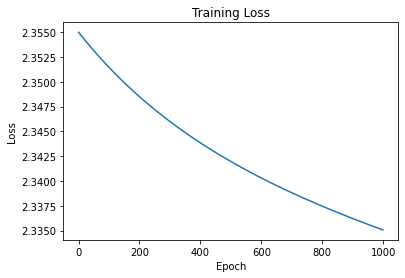

In [126]:
# ppt에서 주어진 값
config = { 'learning_rate' : 0.01,
            'num_epoch' : 1000
          }

model1, vectors1 = train(train_X, train_y, config, 100)

In [127]:
print('\t Accuracy :', eval(model1, vectors1, train_version=True))
print('\t Accuracy :', eval(model1, vectors1, train_version=False))

In train dataset ... 
	 Accuracy : 0.13016666666666668

In test dataset ... 
	 Accuracy : 0.1337


[epoch 1 / 3000] average loss : 2.307318
[epoch 25 / 3000] average loss : 2.305909
[epoch 50 / 3000] average loss : 2.304519
[epoch 75 / 3000] average loss : 2.303202
[epoch 100 / 3000] average loss : 2.301953
[epoch 125 / 3000] average loss : 2.300767
[epoch 150 / 3000] average loss : 2.299639
[epoch 175 / 3000] average loss : 2.298566
[epoch 200 / 3000] average loss : 2.297544
[epoch 225 / 3000] average loss : 2.296570
[epoch 250 / 3000] average loss : 2.295640
[epoch 275 / 3000] average loss : 2.294752
[epoch 300 / 3000] average loss : 2.293902
[epoch 325 / 3000] average loss : 2.293088
[epoch 350 / 3000] average loss : 2.292309
[epoch 375 / 3000] average loss : 2.291561
[epoch 400 / 3000] average loss : 2.290843
[epoch 425 / 3000] average loss : 2.290153
[epoch 450 / 3000] average loss : 2.289489
[epoch 475 / 3000] average loss : 2.288850
[epoch 500 / 3000] average loss : 2.288234
[epoch 525 / 3000] average loss : 2.287640
[epoch 550 / 3000] average loss : 2.287066
[epoch 575 / 300

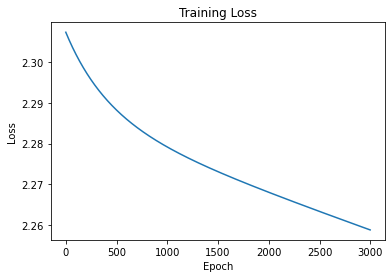

In [128]:
# ppt에서 주어진 값
config = { 'learning_rate' : 0.01,
            'num_epoch' : 3000
          }

model1, vectors1 = train(train_X, train_y, config, 100)

In [130]:
print('\t Accuracy :', eval(model1, vectors1, train_version=True))
print('\t Accuracy :', eval(model1, vectors1, train_version=False))

In train dataset ... 
	 Accuracy : 0.1547

In test dataset ... 
	 Accuracy : 0.1445


[epoch 1 / 5000] average loss : 2.253428
[epoch 25 / 5000] average loss : 2.253032
[epoch 50 / 5000] average loss : 2.252631
[epoch 75 / 5000] average loss : 2.252240
[epoch 100 / 5000] average loss : 2.251858
[epoch 125 / 5000] average loss : 2.251486
[epoch 150 / 5000] average loss : 2.251123
[epoch 175 / 5000] average loss : 2.250768
[epoch 200 / 5000] average loss : 2.250421
[epoch 225 / 5000] average loss : 2.250081
[epoch 250 / 5000] average loss : 2.249749
[epoch 275 / 5000] average loss : 2.249423
[epoch 300 / 5000] average loss : 2.249104
[epoch 325 / 5000] average loss : 2.248791
[epoch 350 / 5000] average loss : 2.248484
[epoch 375 / 5000] average loss : 2.248183
[epoch 400 / 5000] average loss : 2.247887
[epoch 425 / 5000] average loss : 2.247596
[epoch 450 / 5000] average loss : 2.247309
[epoch 475 / 5000] average loss : 2.247028
[epoch 500 / 5000] average loss : 2.246751
[epoch 525 / 5000] average loss : 2.246477
[epoch 550 / 5000] average loss : 2.246208
[epoch 575 / 500

[epoch 4700 / 5000] average loss : 2.213480
[epoch 4725 / 5000] average loss : 2.213298
[epoch 4750 / 5000] average loss : 2.213115
[epoch 4775 / 5000] average loss : 2.212933
[epoch 4800 / 5000] average loss : 2.212750
[epoch 4825 / 5000] average loss : 2.212568
[epoch 4850 / 5000] average loss : 2.212386
[epoch 4875 / 5000] average loss : 2.212204
[epoch 4900 / 5000] average loss : 2.212022
[epoch 4925 / 5000] average loss : 2.211840
[epoch 4950 / 5000] average loss : 2.211658
[epoch 4975 / 5000] average loss : 2.211476
[epoch 5000 / 5000] average loss : 2.211294


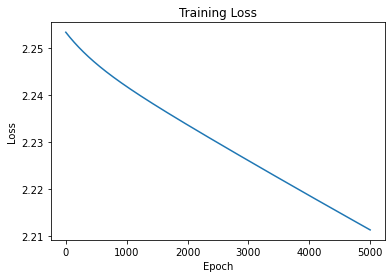

In [135]:
# ppt에서 주어진 값
config = { 'learning_rate' : 0.01,
            'num_epoch' : 5000
          }

model1, vectors1 = train(train_X, train_y, config, 100)

In [136]:
print('\t Accuracy :', eval(model1, vectors1, train_version=True))
print('\t Accuracy :', eval(model1, vectors1, train_version=False))

In train dataset ... 
	 Accuracy : 0.19525

In test dataset ... 
	 Accuracy : 0.2017


## [ 심화 문제 ]

In [141]:
# Activation function
class Relu:
    def __init__(self) :
        self.mask =None
    
    def forward(self, x) :
        self.mask = (x < 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout) :
        dout[self.mask] = 0
        return dout    

In [142]:
def eval(model, train_version = True) :
    if train_version :
        x = train_X
        labels = train_y.squeeze()
        print('In train dataset ... ')
    else : 
        x = test_X
        labels = test_y.squeeze()
        print('\nIn test dataset ... ')
    
    for layer in model.values() :
        if isinstance(layer, Softmax_with_CrossEntropy) :
            x = layer.softmax_forward(x)
        else :
            x = layer.forward(x)
            
    preds = x.argmax(axis=1)
    acc = np.sum(np.where(preds==labels, True, False))/len(labels)
    return acc

In [143]:
from collections import OrderedDict

def train_MLP(config, M) :
    # 손실 이력을 저장하는 리스트
    loss_history = []
    
    lr, num_epoch = config['learning_rate'], config['num_epoch']
    print_loss_interval = 25
    
    layer1 = Linear(784, M)
    activation_function = Relu()
    layer2 = Linear(M, 10)
    softmax_with_CE = Softmax_with_CrossEntropy()
    
    for iter in range(num_epoch) :
        # forward
        x = layer1.forward(train_X)
        x = activation_function.forward(x)
        x = layer2.forward(x)
        preds = softmax_with_CE.softmax_forward(x)
        
        # loss
        one_hot_labels = make_one_hot(train_y)
        losses = softmax_with_CE.crossEntropy_forward(preds, one_hot_labels)
        loss = losses.sum()/len(preds)
        
        # 손실 이력에 손실 값을 추가
        loss_history.append(loss)
        
        # backward
        dL = softmax_with_CE.backward()
        dL = layer2.backward(dL, lr)
        dL = activation_function.backward(dL)
        dL = layer1.backward(dL, lr)
        
        if iter == 0 or (iter+1) % print_loss_interval == 0:
            print("[epoch %d / %d] average loss : %f" % (iter+1, num_epoch, loss))
    
    # 손실 그래프
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    
    model = OrderedDict()
    model['layer1'] = layer1
    model['activation_function'] = activation_function
    model['layer2'] = layer2
    model['softmax_with_CE'] = softmax_with_CE
    
    return model

### M = 10

[epoch 1 / 100] average loss : 12.006362
[epoch 25 / 100] average loss : 9.891954
[epoch 50 / 100] average loss : 8.204434
[epoch 75 / 100] average loss : 6.961343
[epoch 100 / 100] average loss : 6.007775


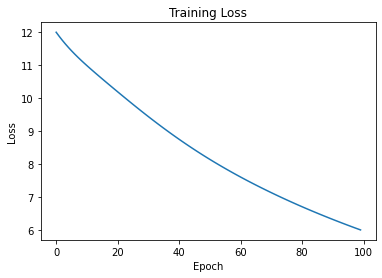

In [145]:
config2 = { 'learning_rate' : 0.01,
            'num_epoch' : 100,
          }

model2 = train_MLP(config2, 10)

In [147]:
print('\t Accuracy :', eval(model2, train_version=True))
print('\t Accuracy :', eval(model2, train_version=False))

In train dataset ... 
	 Accuracy : 0.23741666666666666

In test dataset ... 
	 Accuracy : 0.226


[epoch 1 / 1000] average loss : 11.003218
[epoch 25 / 1000] average loss : 9.378716
[epoch 50 / 1000] average loss : 7.726196
[epoch 75 / 1000] average loss : 6.496930
[epoch 100 / 1000] average loss : 5.593101
[epoch 125 / 1000] average loss : 4.903661
[epoch 150 / 1000] average loss : 4.376576
[epoch 175 / 1000] average loss : 3.969630
[epoch 200 / 1000] average loss : 3.651727
[epoch 225 / 1000] average loss : 3.400926
[epoch 250 / 1000] average loss : 3.200345
[epoch 275 / 1000] average loss : 3.036960
[epoch 300 / 1000] average loss : 2.902071
[epoch 325 / 1000] average loss : 2.789747
[epoch 350 / 1000] average loss : 2.695663
[epoch 375 / 1000] average loss : 2.616111
[epoch 400 / 1000] average loss : 2.548458
[epoch 425 / 1000] average loss : 2.490226
[epoch 450 / 1000] average loss : 2.439426
[epoch 475 / 1000] average loss : 2.394532
[epoch 500 / 1000] average loss : 2.354491
[epoch 525 / 1000] average loss : 2.318496
[epoch 550 / 1000] average loss : 2.285732
[epoch 575 / 10

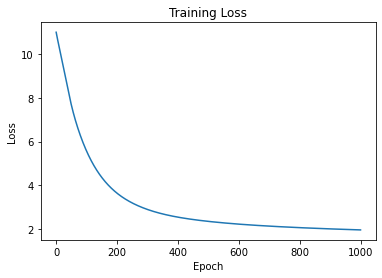

In [148]:
config2 = { 'learning_rate' : 0.01,
            'num_epoch' : 1000,
          }

model2 = train_MLP(config2, 10)

In [149]:
print('\t Accuracy :', eval(model2, train_version=True))
print('\t Accuracy :', eval(model2, train_version=False))

In train dataset ... 
	 Accuracy : 0.3857333333333333

In test dataset ... 
	 Accuracy : 0.3953


### M = 100

[epoch 1 / 100] average loss : 14.447614
[epoch 25 / 100] average loss : 12.655618
[epoch 50 / 100] average loss : 10.691453
[epoch 75 / 100] average loss : 9.145022
[epoch 100 / 100] average loss : 7.993108


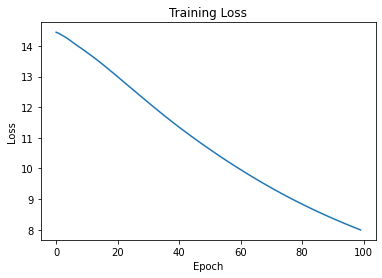

In [151]:
config2 = { 'learning_rate' : 0.01,
            'num_epoch' : 100,
          }

model2 = train_MLP(config2, 100)

In [152]:
print('\t Accuracy :', eval(model2, train_version=True))
print('\t Accuracy :', eval(model2, train_version=False))

In train dataset ... 
	 Accuracy : 0.42023333333333335

In test dataset ... 
	 Accuracy : 0.4364


[epoch 1 / 1000] average loss : 14.450482
[epoch 25 / 1000] average loss : 12.316424
[epoch 50 / 1000] average loss : 10.285314
[epoch 75 / 1000] average loss : 8.594777
[epoch 100 / 1000] average loss : 7.513414
[epoch 125 / 1000] average loss : 6.743591
[epoch 150 / 1000] average loss : 6.169003
[epoch 175 / 1000] average loss : 5.724845
[epoch 200 / 1000] average loss : 5.367582
[epoch 225 / 1000] average loss : 5.072203
[epoch 250 / 1000] average loss : 4.823109
[epoch 275 / 1000] average loss : 4.607136
[epoch 300 / 1000] average loss : 4.418648
[epoch 325 / 1000] average loss : 4.253325
[epoch 350 / 1000] average loss : 4.106564
[epoch 375 / 1000] average loss : 3.975128
[epoch 400 / 1000] average loss : 3.856474
[epoch 425 / 1000] average loss : 3.748547
[epoch 450 / 1000] average loss : 3.649684
[epoch 475 / 1000] average loss : 3.558786
[epoch 500 / 1000] average loss : 3.474600
[epoch 525 / 1000] average loss : 3.396117
[epoch 550 / 1000] average loss : 3.322757
[epoch 575 / 

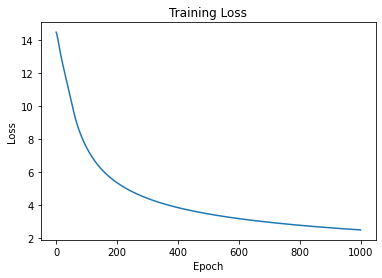

In [158]:
config2 = { 'learning_rate' : 0.01,
            'num_epoch' : 1000,
          }

model2 = train_MLP(config2, 100)

In [159]:
print('\t Accuracy :', eval(model2, train_version=True))
print('\t Accuracy :', eval(model2, train_version=False))

In train dataset ... 
	 Accuracy : 0.78065

In test dataset ... 
	 Accuracy : 0.7853


[epoch 1 / 3000] average loss : 14.542676
[epoch 25 / 3000] average loss : 12.530079
[epoch 50 / 3000] average loss : 10.725144
[epoch 75 / 3000] average loss : 9.276177
[epoch 100 / 3000] average loss : 8.173302
[epoch 125 / 3000] average loss : 7.348015
[epoch 150 / 3000] average loss : 6.711755
[epoch 175 / 3000] average loss : 6.205942
[epoch 200 / 3000] average loss : 5.793925
[epoch 225 / 3000] average loss : 5.447375
[epoch 250 / 3000] average loss : 5.154200
[epoch 275 / 3000] average loss : 4.904141
[epoch 300 / 3000] average loss : 4.686510
[epoch 325 / 3000] average loss : 4.494402
[epoch 350 / 3000] average loss : 4.323423
[epoch 375 / 3000] average loss : 4.170928
[epoch 400 / 3000] average loss : 4.033612
[epoch 425 / 3000] average loss : 3.908873
[epoch 450 / 3000] average loss : 3.795052
[epoch 475 / 3000] average loss : 3.690843
[epoch 500 / 3000] average loss : 3.594962
[epoch 525 / 3000] average loss : 3.506698
[epoch 550 / 3000] average loss : 3.425363
[epoch 575 / 

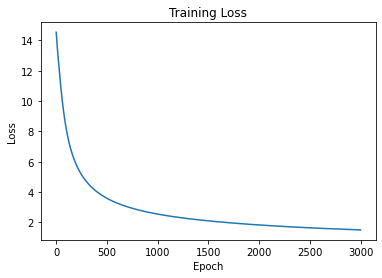

In [160]:
config2 = { 'learning_rate' : 0.01,
            'num_epoch' : 3000,
          }

model2 = train_MLP(config2, 100)

In [161]:
print('\t Accuracy :', eval(model2, train_version=True))
print('\t Accuracy :', eval(model2, train_version=False))

In train dataset ... 
	 Accuracy : 0.8445666666666667

In test dataset ... 
	 Accuracy : 0.8446
